In [6]:
from datasets import load_dataset, DatasetDict
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,T5ForConditionalGeneration
from pprint import pprint
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams
from collections import Counter

from Model import Model_Class
import yaml
import json
from tqdm import tqdm
import os
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
Base_config = yaml.load(open("config.yml"),Loader=yaml.FullLoader)
Baseline = Model_Class(Base_config)

04/06/2024 06:05:10 - INFO - Model -   Finish loading model [223M] from Salesforce/codet5-base


### Generate Data

In [8]:
from data import gen_data

In [9]:
print(open("data/gen_data.py","r").read())

def main():
    import argparse
    import datasets
    from tqdm import tqdm
    from datasets import load_dataset 
    import pandas as pd
    import random
    import json

    parser = argparse.ArgumentParser(description="Just an example",
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--split", default=0.2, help="split between train and validation")
    parser.add_argument("--seed", default=2024, help="seed for randomizing split")
    args = parser.parse_args()

    PROMPT_DICT = """
    ### Question
    Write an SQL query that answers this question:
    {question}

    ### Context
    The query will run on a database with the following schema:
    {context}
    """
    
    print("Loading Data From HuggingFace: Clinton/Text-to-sql-v1")
    Clinton_dataset = load_dataset("Clinton/Text-to-sql-v1")
    print("Loading Data From HuggingFace: b-mc2/sql-create-context")
    b_mc2_dataset = load_dataset("b-mc2/sql-crea

In [10]:
!cd data; python gen_data.py

Loading Data From HuggingFace: Clinton/Text-to-sql-v1
Loading Data From HuggingFace: b-mc2/sql-create-context
Loading Data From HuggingFace: gretelai/synthetic_text_to_sql
Mapping Data Points to Prompt: 100%|█| 440785/440785 [00:13<00:00, 33469.77it/s]
Randomizing List Values
Writing Data to train.json: 100%|███| 352628/352628 [00:02<00:00, 125404.50it/s]
Writing Data to validation.json: 100%|█| 44078/44078 [00:00<00:00, 125222.95it/s
Writing Data to testing.json: 100%|███| 44079/44079 [00:00<00:00, 125448.75it/s]


### Check for tokens out of range for model (>512)

In [11]:
inputs = []
all_len = []
new_len = []
with open("data/train.json") as f:
    for line in tqdm(f, desc="Removing data with over 512 tokens"):
        text = json.loads(line)
        line_len = len(Baseline.tokenizer(text["nl"]).input_ids)
        all_len.append(line_len)
        if line_len < 513:
            inputs.append(text)
            new_len.append(line_len)
with open("data/train_filtered.json","w") as f:
    for x in tqdm(inputs, desc="Writing Data to train.json"):
        json.dump(x,f,indent=None,default=str)
        f.write("\n")
    f.close()

Removing data with over 512 tokens: 0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1593 > 512). Running this sequence through the model will result in indexing errors
Removing data with over 512 tokens: 352628it [02:00, 2915.45it/s]
Writing Data to train.json: 100%|██████████| 314887/314887 [00:01<00:00, 161826.60it/s]


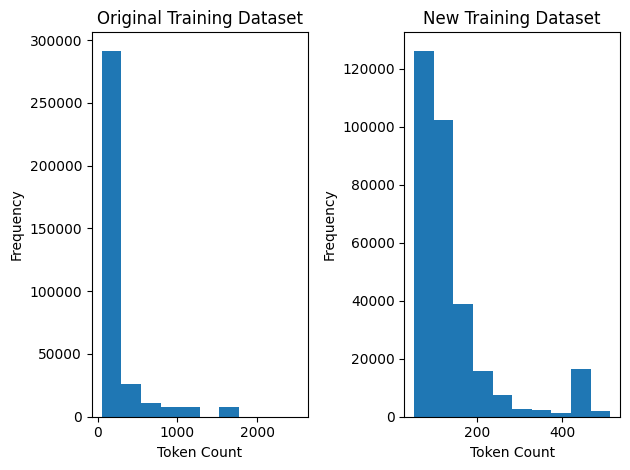

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(all_len)
ax1.set_title("Original Training Dataset")
ax1.set(xlabel="Token Count", ylabel="Frequency")
ax2.hist(new_len)
ax2.set_title("New Training Dataset")
ax2.set(xlabel="Token Count", ylabel="Frequency")
fig.tight_layout()
plt.show()

In [13]:
inputs = []
all_len = []
new_len = []
with open("data/validation.json") as f:
    for line in tqdm(f, desc="Removing data with over 512 tokens"):
        text = json.loads(line)
        line_len = len(Baseline.tokenizer(text["nl"]).input_ids)
        all_len.append(line_len)
        if line_len < 513:
            inputs.append(text)
            new_len.append(line_len)
with open("data/validation_filtered.json","w") as f:
    for x in tqdm(inputs, desc="Writing Data to train.json"):
        json.dump(x,f,indent=None,default=str)
        f.write("\n")
    f.close()

Removing data with over 512 tokens: 44078it [00:15, 2865.39it/s]
Writing Data to train.json: 100%|██████████| 39221/39221 [00:00<00:00, 156217.31it/s]


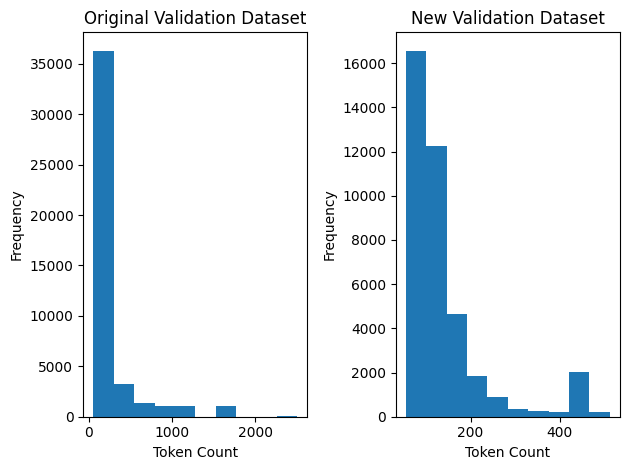

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(all_len)
ax1.set_title("Original Validation Dataset")
ax1.set(xlabel="Token Count", ylabel="Frequency")
ax2.hist(new_len)
ax2.set_title("New Validation Dataset")
ax2.set(xlabel="Token Count", ylabel="Frequency")
fig.tight_layout()
plt.show()

In [15]:
inputs = []
all_len = []
new_len = []
with open("data/testing.json") as f:
    for line in tqdm(f, desc="Removing data with over 512 tokens"):
        text = json.loads(line)
        line_len = len(Baseline.tokenizer(text["nl"]).input_ids)
        all_len.append(line_len)
        if line_len < 513:
            inputs.append(text)
            new_len.append(line_len)
with open("data/testing_filtered.json","w") as f:
    for x in tqdm(inputs, desc="Writing Data to train.json"):
        json.dump(x,f,indent=None,default=str)
        f.write("\n")
    f.close()

Removing data with over 512 tokens: 44079it [00:15, 2909.58it/s]
Writing Data to train.json: 100%|██████████| 39340/39340 [00:00<00:00, 158856.19it/s]


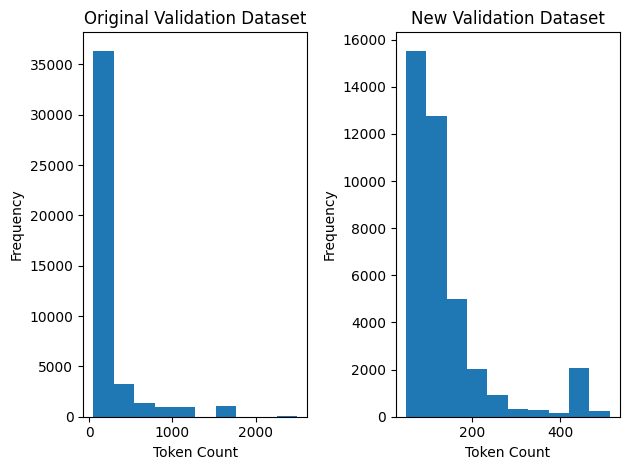

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(all_len)
ax1.set_title("Original Validation Dataset")
ax1.set(xlabel="Token Count", ylabel="Frequency")
ax2.hist(new_len)
ax2.set_title("New Validation Dataset")
ax2.set(xlabel="Token Count", ylabel="Frequency")
fig.tight_layout()
plt.show()

### Count occurrence of SQL key words

In [17]:
import re
from collections import Counter
keywords = ['SELECT', 'LEFT', 'CROSS', 'WITH','ORDER','LIMIT', 'AND', 'OR','LIKE','%','BETWEEN', 'OUTER', 'JOIN', 'WHERE', 'GROUP BY', 'HAVING']
keyword_counts = Counter({keyword: 0 for keyword in keywords})
patterns = {keyword: re.compile(r'\b' + keyword + r'\b', re.IGNORECASE) for keyword in keywords}

with open("data/train_filtered.json") as f:
    for x in f.readlines():
            for keyword, pattern in patterns.items():
                if pattern.search(json.loads(x)["code"]):
                    keyword_counts[keyword] += 1

sorted_keyword_counts = sorted(keyword_counts.items(), key=lambda item: item[1], reverse=True)

# Display the counts
for keyword, count in sorted_keyword_counts:
    print(f"{keyword}: {count}")

SELECT: 307589
WHERE: 273231
AND: 95548
GROUP BY: 40540
JOIN: 34643
ORDER: 24043
LIMIT: 8792
BETWEEN: 5020
LIKE: 2864
OR: 2641
HAVING: 2631
LEFT: 1229
WITH: 772
CROSS: 106
OUTER: 64
%: 20


In [18]:
import re
from collections import Counter
keywords = ['SELECT', 'LEFT', 'CROSS', 'WITH','ORDER','LIMIT', 'AND', 'OR','LIKE','%','BETWEEN', 'OUTER', 'JOIN', 'WHERE', 'GROUP BY', 'HAVING']
keyword_counts = Counter({keyword: 0 for keyword in keywords})
patterns = {keyword: re.compile(r'\b' + keyword + r'\b', re.IGNORECASE) for keyword in keywords}

with open("data/validation_filtered.json") as f:
    for x in f.readlines():
            for keyword, pattern in patterns.items():
                if pattern.search(json.loads(x)["code"]):
                    keyword_counts[keyword] += 1

sorted_keyword_counts = sorted(keyword_counts.items(), key=lambda item: item[1], reverse=True)

# Display the counts
for keyword, count in sorted_keyword_counts:
    print(f"{keyword}: {count}")

SELECT: 38331
WHERE: 33991
AND: 11769
GROUP BY: 5136
JOIN: 4315
ORDER: 3067
LIMIT: 1108
BETWEEN: 635
LIKE: 397
HAVING: 370
OR: 340
LEFT: 130
WITH: 101
CROSS: 17
OUTER: 10
%: 2


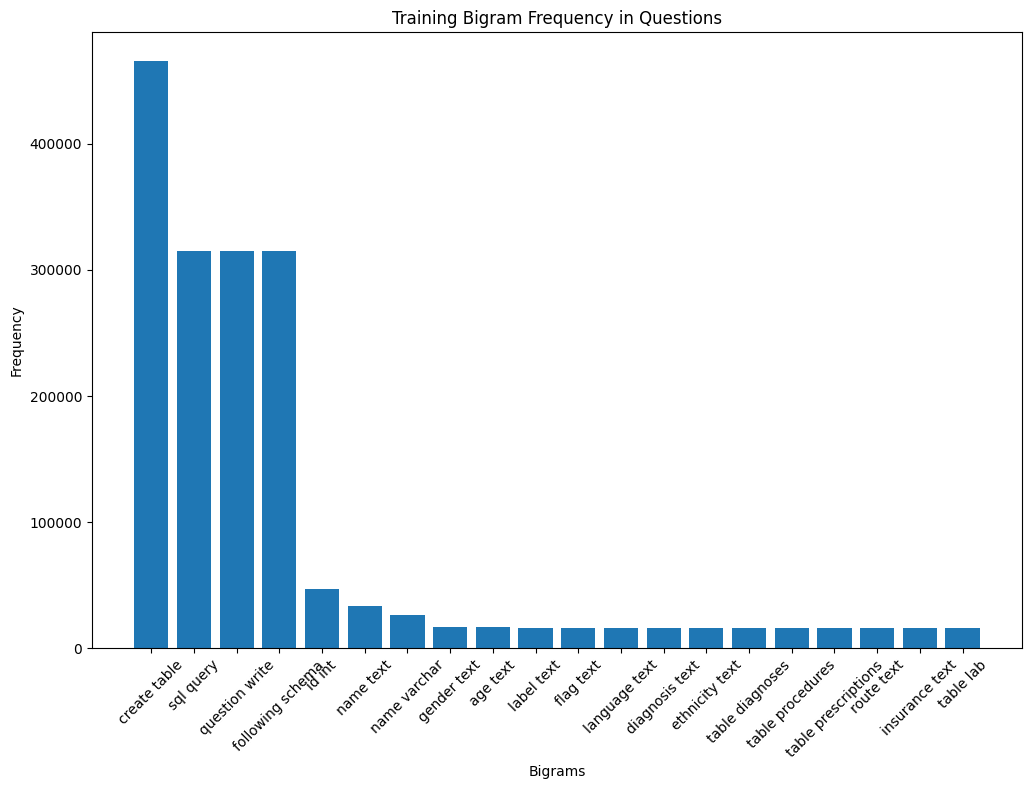

In [19]:
stop_words = set(stopwords.words('english'))
validation_dataset = open("data/train_filtered.json")
filtered_bigrams = [
    (w1.lower(), w2.lower())
    for question in validation_dataset.readlines()
    for w1, w2 in bigrams(word_tokenize(json.loads(question)["nl"]))
    if w1.isalpha() and w2.isalpha() and w1.lower() not in stop_words and w2.lower() not in stop_words
]

# Count the frequency of each bigram
bigram_counts = Counter(filtered_bigrams)

# Sort bigrams by frequency
sorted_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)

# Unzip the bigrams and their frequencies
bigrams, frequencies = zip(*sorted_bigrams)

# Convert bigram tuples to strings for plotting
bigram_strings = [' '.join(bigram) for bigram in bigrams]

# Plotting
plt.figure(figsize=(12, 8))  # Optional: Adjust the figure size as needed
plt.bar(bigram_strings[:20], frequencies[:20])  # Plotting top 20 bigrams for readability
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the bigrams on the x-axis to make them readable
plt.title('Training Bigram Frequency in Questions')
plt.show()